In [1]:
import geopandas as gpd
from shapely.geometry import LineString, Point
from shapely.ops import unary_union
from geopandas import clip
from shapely.ops import nearest_points
import numpy as np
from shapely.geometry import box
import xugrid as xu
import xarray as xr

In [2]:
coastline_path = r"p:\11210471-001-compass\code\From Fernaldi\For_COMPASS\For_COMPASS\\qgis\0m_GEBCO_line.gpkg"  # To represent coastline, I made it using qgis
obs_path       = r"p:\11210471-001-compass\code\From Fernaldi\For_COMPASS\For_COMPASS\\qgis\obs_sfincs.gpkg"
bbox_path      = r"p:\11210471-001-compass\code\From Fernaldi\For_COMPASS\For_COMPASS\\qgis\SFINCS_bbox.gpkg"
crs_utm        = "EPSG:32736"
# transect_length = 2000  # total length in meters (1000 m each side)
transect_length = 3000  # total length in meters (1000 m each side)

# ig_snap_path   = r"p:\11210471-001-compass\code\SFINCS\SFINCS_Idai_Wave_Tim\with_snapwave_nowindgrowth\sfincs_map.nc" # FIXME - is without IG, but instead for now the 'nowindgrowth' run
snap_only_path = r"p:\11210471-001-compass\code\SFINCS\SFINCS_Idai_Wave_Tim\with_snapwave_longer\sfincs_map.nc"
wl_only_path   = r"p:\11210471-001-compass\code\SFINCS\SFINCS_Idai_Wave_Tim\without_snapwave_longer\sfincs_map.nc"
# t0,t1          = "2019-03-14","2019-03-16"  # For time slice
t0,t1          = "2019-03-09","2019-03-25 06:00:00"  # For time slice > v03
# t0,t1          = "2019-03-09","2019-03-25 00:00:00"  # For time slice > v03b FIXME - try this?

# 2019-03-09 00:00:00 tot 2019-03-25 06:00:00

**1. Make Transect for Wave Setup and Ig Wave Analysis**

In [3]:
bbox_gdf = gpd.read_file(bbox_path).to_crs(crs_utm)
bbox_geom = bbox_gdf.geometry.union_all()
coast = gpd.read_file(coastline_path).to_crs(crs_utm)
obs   = gpd.read_file(obs_path).to_crs(crs_utm)
coast_clipped = clip(coast, bbox_geom)
obs_clipped   = clip(obs, bbox_geom)
coast_line = coast_clipped.geometry.iloc[0]
coast_coords = list(coast_line.coords)

In [4]:
# Function: find closest segment and build perpendicular transect
def make_perpendicular_transect(point, line, coords, length=1000):
    # Snap point to line
    snapped_point = line.interpolate(line.project(point))
    
    # Find closest segment (between two points)
    min_dist = float('inf')
    closest_seg = None
    for i in range(len(coords) - 1):
        seg = LineString([coords[i], coords[i+1]])
        dist = seg.distance(snapped_point)
        if dist < min_dist:
            min_dist = dist
            closest_seg = seg

    # Segment direction vector
    x0, y0 = closest_seg.coords[0]
    x1, y1 = closest_seg.coords[1]
    dx, dy = x1 - x0, y1 - y0

    # Normalize and rotate 90 degrees (perpendicular)
    norm = np.hypot(dx, dy)
    ux, uy = -dy / norm, dx / norm  # clockwise ⟶ cross-shore

    # Build transect: length/2 in each direction
    x, y = snapped_point.x, snapped_point.y
    p1 = Point(x + ux * length, y + uy * length)
    p2 = Point(x - ux * length / 2, y - uy * length / 2)
    return LineString([p1, p2])

In [5]:
# Apply to all points
transects = []
for pt in obs_clipped.geometry:
    transect = make_perpendicular_transect(pt, coast_line, coast_coords, transect_length)
    transects.append(transect)

# Build GeoDataFrame of transects
gdf_transects = gpd.GeoDataFrame(geometry=transects, crs=crs_utm)
# gdf_transects.to_crs("EPSG:4326").to_file(".\perpendicular_transects.gpkg", driver="GPKG")
# gdf_transects.to_crs("EPSG:4326").to_file(".\perpendicular_transects_v02.gpkg", driver="GPKG")
# gdf_transects.to_crs("EPSG:4326").to_file(".\perpendicular_transects_v03.gpkg", driver="GPKG")
gdf_transects.to_crs("EPSG:4326").to_file(".\perpendicular_transects_v05.gpkg", driver="GPKG")

# gdf_transects.to_crs("EPSG:4326").to_file(".\qgis\perpendicular_transects.gpkg", driver="GPKG")

**2. Load SFINCS' Result**

In [6]:
# ig_snap   = xu.open_dataset(ig_snap_path)
snap_only = xu.open_dataset(snap_only_path)
wl_only   = xu.open_dataset(wl_only_path)

In [7]:
snap_only

<xarray.Dataset> Size: 70GB
Dimensions:        (nmesh2d_node: 2728888, nmesh2d_face: 682222, time: 2341,
                    timemax: 17, runtime: 1)
Coordinates:
  * time           (time) datetime64[ns] 19kB 2019-03-09 ... 2019-03-25T06:00:00
  * timemax        (timemax) datetime64[ns] 136B 2019-03-10 ... 2019-03-25T06...
  * nmesh2d_node   (nmesh2d_node) int64 22MB 0 1 2 3 ... 2728885 2728886 2728887
  * nmesh2d_face   (nmesh2d_face) int64 5MB 0 1 2 3 ... 682219 682220 682221
Dimensions without coordinates: runtime
Data variables: (12/23)
    inp            int32 4B ...
    mesh2d_node_x  (nmesh2d_node) float64 22MB ...
    mesh2d_node_y  (nmesh2d_node) float64 22MB ...
    crs            int32 4B ...
    zb             (nmesh2d_face) float32 3MB ...
    msk            (nmesh2d_face) float64 5MB ...
    ...             ...
    beta           (time, nmesh2d_face) float32 6GB ...
    snapwavedepth  (time, nmesh2d_face) float32 6GB ...
    wavdir         (time, nmesh2d_face) float32 6GB ...
    total_runtime  (runtime) float32 4B ...
    average_dt     (runtime) float32 4B ...
    status         (runtime) float32 4B ...
Attributes:
    Conventions:                         Conventions = 'CF-1.8 UGRID-1.0 Delt...
    Build-Revision-Date-Netcdf-library:  4.8.1 of Sep 29 2021 09:36:14 $
    Producer:                            SFINCS model: Super-Fast INundation ...
    Build-Revision:                      $Rev: v2.2.1-alpha col d'Eze
    Build-Date:                          $Date: 2025-07-03
    title:                               SFINCS map netcdf output

**3. Slice Only to Peak Wave Height Time Period**

In [8]:
t0, t1 = np.datetime64(t0), np.datetime64(t1)
# ig_snap   = ig_snap.sel(time=slice(t0, t1))
snap_only = snap_only.sel(time=slice(t0, t1))
wl_only   = wl_only.sel(time=slice(t0, t1))

**4. Calculate Maximum Setup and IG Wave**

In [9]:
# ig_wl = (ig_snap["zs"] - wl_only["zs"]).max(dim="time") #FIXME
# ig_wl = (ig_snap["zs"] - snap_only["zs"]).max(dim="time")

setup_wl = (snap_only["zs"] - wl_only["zs"]).max(dim="time")

In [10]:
setup = snap_only["zs"] - wl_only["zs"]
setup

<xarray.DataArray 'zs' (time: 2341, nmesh2d_face: 682222)> Size: 6GB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 19kB 2019-03-09 ... 2019-03-25T06:00:00
  * nmesh2d_face  (nmesh2d_face) int64 5MB 0 1 2 3 ... 682219 682220 682221

In [11]:
check = setup.max(dim="time") - setup_wl
check.max()

<xarray.DataArray 'zs' ()> Size: 8B
array(0.)

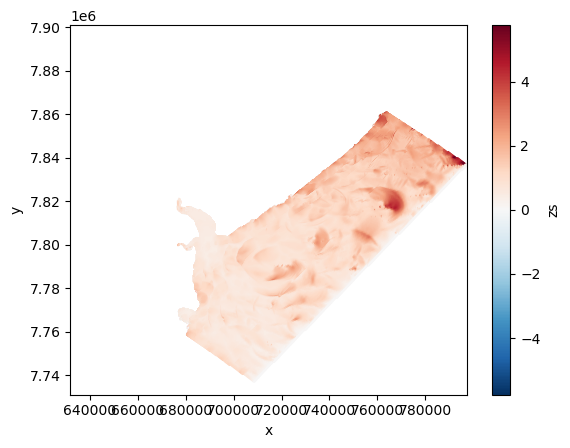

In [12]:
setup_wl.ugrid.plot()


In [13]:
# ig_wl.ugrid.plot()

**5. Calculate Setup and Swash along transect**

In [14]:

# wave_setup = []
# wave_runup = []

# # Number of sample points along each transect
# num_samples = 100

# # Iterate over each transect in the GeoDataFrame
# for transect in gdf_transects.geometry:
#     # Generate evenly spaced points along the transect
#     sampled_points = [transect.interpolate(i / num_samples, normalized=True) for i in range(num_samples + 1)]
#     x_coords = np.array([point.x for point in sampled_points])
#     y_coords = np.array([point.y for point in sampled_points])

#     wave_setup_point = setup_wl.ugrid.sel(x=x_coords, y=y_coords)
#     wave_runup_point = ig_wl.ugrid.sel(x=x_coords, y=y_coords)

#     # Calculate mean and max along the selected transect values
#     wave_setup_max = wave_setup_point.max().item()
#     wave_runup_max = wave_runup_point.max().item()

#     wave_setup.append(wave_setup_max)
#     wave_runup.append(wave_runup_max)

In [15]:
gdf_transects.geometry.shape

(81,)

In [16]:
coordinates = list(transect.coords)
coordinates
coordinates[0][0]


765118.5938769043

In [17]:
import matplotlib.pyplot  as plt

In [18]:
# TL: Don't do pointwise, but use intersect_line of xugrid, which might be more precise
wave_setup = []
wave_runup = []
combined_array = xr.DataArray()#data=[])  # No data)
# Iterate over each transect in the GeoDataFrame
for transect in gdf_transects.geometry:

    # get the x&y coordinates from the linestring of transect based on the ends
    coordinates = list(transect.coords)

    wave_setup_point = setup_wl.ugrid.intersect_line(start=(coordinates[0][0], coordinates[0][1]), end=(coordinates[1][0], coordinates[1][1]))
    # wave_runup_point = ig_wl.ugrid.intersect_line(start=(coordinates[0][0], coordinates[0][1]), end=(coordinates[1][0], coordinates[1][1]))

    # Calculate mean and max along the selected transect values
    wave_setup_max = wave_setup_point.max().item()
    # wave_runup_max = wave_runup_point.max().item()

    wave_setup.append(wave_setup_max)
    # wave_runup.append(wave_runup_max)
    
    # plot to quickly check water levels in transect - uncomment to show
    # snap_only['zb'].ugrid.intersect_line(start=(coordinates[0][0], coordinates[0][1]), end=(coordinates[1][0], coordinates[1][1])).plot(x='mesh2d_s', label='zb')
    # snap_only['zs'][200,:].ugrid.intersect_line(start=(coordinates[0][0], coordinates[0][1]), end=(coordinates[1][0], coordinates[1][1])).plot(x='mesh2d_s', label='wl including setup')
    # wl_only['zs'][200,:].ugrid.intersect_line(start=(coordinates[0][0], coordinates[0][1]), end=(coordinates[1][0], coordinates[1][1])).plot(x='mesh2d_s', label='wl only')
    # plt.title('tmp')
    # plt.legend()
    # plt.show()

    # plot to quickly check wave setup in transect - uncomment to show
    # setup_wl.ugrid.intersect_line(start=(coordinates[0][0], coordinates[0][1]), end=(coordinates[1][0], coordinates[1][1])).plot(x='mesh2d_s', label='setup_wl')
    # plt.show()

    wave_setup_transects = setup.ugrid.intersect_line(start=(coordinates[0][0], coordinates[0][1]), end=(coordinates[1][0], coordinates[1][1]))
    # wave_setup_transects
    wave_setup_transects_max = wave_setup_transects.max(dim='nmesh2d_face')#.item() #take max over transect, for every timestep

    # obs_clipped["max_setup_in_transect_over_time"] = wave_setup_transects_max
    # Concatenate along a new dimension
    combined_array = xr.concat([combined_array, wave_setup_transects_max], dim="transects")
    # check plot - uncomment to show:
    # wave_setup_transects_max.plot()
    # plt.show()

In [19]:
len(wave_setup)

81

In [20]:
# Transpose the dimensions
combined_array = combined_array.transpose("time", "transects")
combined_array

<xarray.DataArray (time: 2341, transects: 82)> Size: 2MB
array([[            nan,  1.80763275e-19,  1.85266951e-19, ...,
         1.32544764e-18,  5.28285185e-18,  1.38642560e-17],
       [            nan,  1.24355941e-03,  4.99881944e-03, ...,
         8.15481239e-04,  8.48778989e-03,  2.30920948e-02],
       [            nan,  1.88289571e-03,  6.50641043e-03, ...,
         1.03292312e-03,  1.03714140e-02,  2.21636314e-02],
       ...,
       [            nan,  7.39459991e-01,  1.01650214e+00, ...,
        -4.56858277e-01, -4.13789630e-01, -1.13063216e-01],
       [            nan,  9.52983856e-01,  9.05068874e-01, ...,
        -1.39427900e+00, -1.21724868e+00, -9.31373954e-01],
       [            nan,  7.92975903e-01,  5.79791546e-01, ...,
         5.76537013e-01,  7.28875279e-01, -6.31141663e-03]])
Coordinates:
  * time     (time) datetime64[ns] 19kB 2019-03-09 ... 2019-03-25T06:00:00
Dimensions without coordinates: transects

In [21]:
combined_array[:,0].values 

array([nan, nan, nan, ..., nan, nan, nan])

In [22]:
# drop first column with only Nans, so it becomes size 81 again
combined_array = combined_array[:, 1:]
combined_array

<xarray.DataArray (time: 2341, transects: 81)> Size: 2MB
array([[ 1.80763275e-19,  1.85266951e-19,  2.17322707e-19, ...,
         1.32544764e-18,  5.28285185e-18,  1.38642560e-17],
       [ 1.24355941e-03,  4.99881944e-03,  7.88555481e-03, ...,
         8.15481239e-04,  8.48778989e-03,  2.30920948e-02],
       [ 1.88289571e-03,  6.50641043e-03,  9.51666385e-03, ...,
         1.03292312e-03,  1.03714140e-02,  2.21636314e-02],
       ...,
       [ 7.39459991e-01,  1.01650214e+00,  1.02111673e+00, ...,
        -4.56858277e-01, -4.13789630e-01, -1.13063216e-01],
       [ 9.52983856e-01,  9.05068874e-01,  8.22762966e-01, ...,
        -1.39427900e+00, -1.21724868e+00, -9.31373954e-01],
       [ 7.92975903e-01,  5.79791546e-01,  7.03540325e-01, ...,
         5.76537013e-01,  7.28875279e-01, -6.31141663e-03]])
Coordinates:
  * time     (time) datetime64[ns] 19kB 2019-03-09 ... 2019-03-25T06:00:00
Dimensions without coordinates: transects

In [23]:
obs_clipped["wave_setup"] = wave_setup
# obs_clipped["wave_runup"] = wave_runup
# obs_clipped["swash_IG"] = np.maximum(obs_clipped["wave_runup"] - obs_clipped["wave_setup"], 0)

# total = obs_clipped["wave_setup"] + obs_clipped["swash_IG"]
# total = total.replace(0, np.nan)

# obs_clipped["frac_setup"] = obs_clipped["wave_setup"] / total
# obs_clipped["frac_swash"] = obs_clipped["swash_IG"] / total

c:\Users\leijnse\AppData\Local\miniforge3\envs\hydromt-sfincs-insiders\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


**6. Plot Contribution**

In [24]:
obs_clipped["lat"] = obs_clipped.geometry.y
gdf_3857 = obs_clipped.to_crs(epsg=3857)
xmin, ymin, xmax, ymax = gdf_3857.total_bounds
margin = 20_000

# Bar plot layout
lat = obs_clipped.to_crs("EPSG:4326").geometry.y     # degrees, not metres
y_min, y_max = lat.min(), lat.max()
bar_h = (y_max - y_min) / len(lat) * 0.6


c:\Users\leijnse\AppData\Local\miniforge3\envs\hydromt-sfincs-insiders\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [25]:
gdf_3857.to_file(".\max_wave_setup_v03.geojson", driver="geojson")


In [26]:
gdf_3857

,name,geometry,wave_setup,lat
54,dfm_point54,POINT (3872099.929 -2293934.553),0.952984,7.768002e+06
55,dfm_point55,POINT (3872947.497 -2291969.561),1.016502,7.769828e+06
56,dfm_point56,POINT (3873459.345 -2289942.591),1.021117,7.771715e+06
57,dfm_point57,POINT (3873311.686 -2287805.848),1.545740,7.773711e+06
58,dfm_point58,POINT (3873164.079 -2285669.342),1.600267,7.775708e+06
...,...,...,...,...
125,dfm_point125,POINT (3948984.025 -2203571.875),2.266009,7.851654e+06
126,dfm_point126,POINT (3950257.253 -2201868.211),2.268804,7.853235e+06
127,dfm_point127,POINT (3951525.014 -2200160.832),3.477159,7.854820e+06
128,dfm_point128,POINT (3952728.081 -2198406.82),3.715806,7.856450e+06


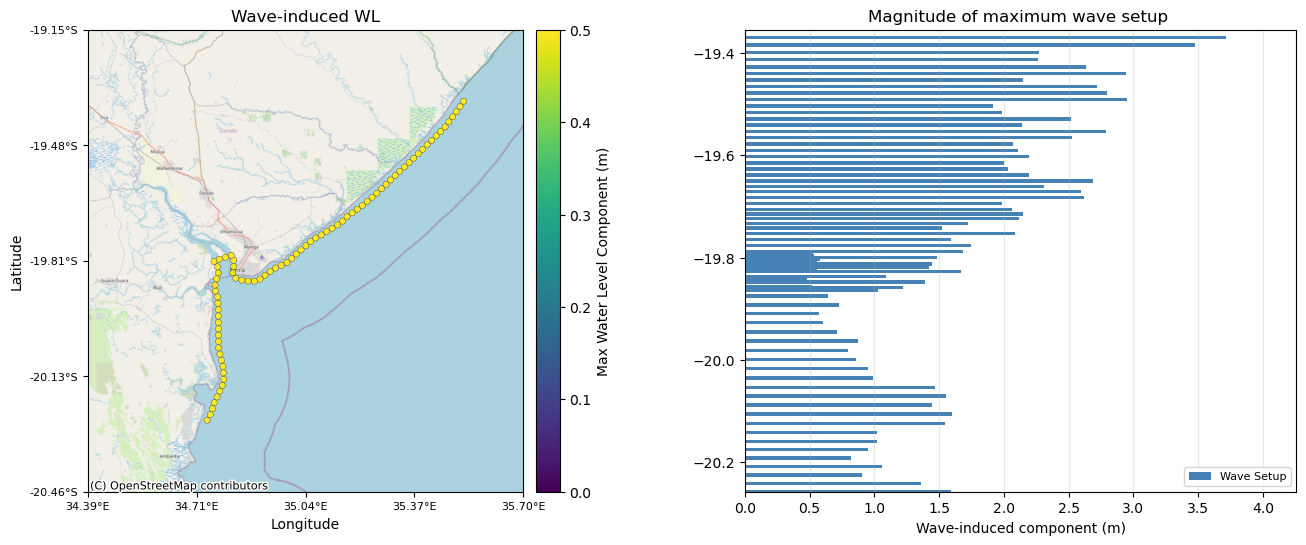

In [27]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import TwoSlopeNorm
import contextily as ctx
from pyproj import Transformer

fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.2, 1], wspace=0.3)

transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)

# Color scale
vmin = 0.0
vmax = 0.5#gdf_3857["max_component"].max()
vcenter = (vmin + vmax) / 2.0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# ------------------------------------------------------------------
# MAP: max(wave_setup, wave_runup)
# ------------------------------------------------------------------
ax_map = fig.add_subplot(gs[0, 0])
ax_map.set_xlim(xmin - 2 * margin, xmax + margin)
ax_map.set_ylim(ymin - 1.2 * margin, ymax + 1.2* margin)

gdf_3857.plot(
    ax=ax_map,
    column="wave_setup",
    cmap="viridis",
    norm=norm,
    markersize=20,
    edgecolor="k",
    linewidth=0.2
)

ctx.add_basemap(ax_map, source=ctx.providers.OpenStreetMap.Mapnik, crs=gdf_3857.crs)

# Axis labels
lon_ticks = np.linspace(*ax_map.get_xlim(), 5)
lat_ticks = np.linspace(*ax_map.get_ylim(), 5)
ax_map.set_xticks(lon_ticks)
ax_map.set_yticks(lat_ticks)
ax_map.set_xticklabels([f"{transformer.transform(x, ymin)[0]:.2f}°E" for x in lon_ticks], fontsize=8)
ax_map.set_yticklabels([f"{transformer.transform(xmin, y)[1]:.2f}°S" for y in lat_ticks], fontsize=8)
ax_map.set_xlabel("Longitude")
ax_map.set_ylabel("Latitude")
ax_map.set_title("Wave-induced WL", fontsize=12)

# Colorbar
sm = plt.cm.ScalarMappable(norm=norm, cmap="viridis")
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax_map, orientation="vertical", fraction=0.04, pad=0.02)
cbar.set_label("Max Water Level Component (m)")

# ------------------------------------------------------------------
# BAR CHART 1: Absolute difference
# ------------------------------------------------------------------
ax_abs = fig.add_subplot(gs[0, 1])

# Plot setup
ax_abs.barh(lat, obs_clipped["wave_setup"],
            height=bar_h, color="steelblue", label="Wave Setup")

# Plot swash_IG only where positive (on top of setup)
# ax_abs.barh(lat, obs_clipped["swash_IG"],
#             left=obs_clipped["wave_setup"],
#             height=bar_h, color="orange", label="IG Swash")

ax_abs.set_ylim(y_min, y_max)
ax_abs.set_xlabel("Wave-induced component (m)")
ax_abs.set_title("Magnitude of maximum wave setup ")
ax_abs.grid(axis="x", alpha=0.3)
ax_abs.legend(fontsize=8, loc="lower right")


# ------------------------------------------------------------------
# BAR CHART 2: Relative contribution
# ------------------------------------------------------------------
# ax_rel = fig.add_subplot(gs[0, 2], sharey=ax_abs)
# ax_rel.barh(lat, obs_clipped["frac_setup"],
#             height=bar_h, color="steelblue", label="Setup")
# ax_rel.barh(lat, obs_clipped["frac_swash"],
#             left=obs_clipped["frac_setup"],
#             height=bar_h, color="orange", label="IG Swash")

# ax_rel.set_xlim(0, 1)
# ax_rel.set_ylim(y_min, y_max)
# ax_rel.set_xlabel("Relative contribution")
# ax_rel.set_title("Relative Setup vs. IG Swash")
# ax_rel.grid(axis="x", alpha=0.3)
# ax_rel.legend(fontsize=8, loc="lower right")

fig.savefig("max_wave_setup_analysis_v03.png", dpi=300, bbox_inches="tight")

In [28]:
# add also coordinates to our new Xarray dataarray 'combined_array':

# Update the DataArray with new x and y coordinates
combined_array = combined_array.assign_coords(x=('transects', obs_clipped.geometry.x.values), y=('transects', obs_clipped.geometry.y.values))
# Set the CRS attribute
combined_array.attrs['crs'] = 'EPSG:3857'  # Replace with your actual CRS

combined_array

<xarray.DataArray (time: 2341, transects: 81)> Size: 2MB
array([[ 1.80763275e-19,  1.85266951e-19,  2.17322707e-19, ...,
         1.32544764e-18,  5.28285185e-18,  1.38642560e-17],
       [ 1.24355941e-03,  4.99881944e-03,  7.88555481e-03, ...,
         8.15481239e-04,  8.48778989e-03,  2.30920948e-02],
       [ 1.88289571e-03,  6.50641043e-03,  9.51666385e-03, ...,
         1.03292312e-03,  1.03714140e-02,  2.21636314e-02],
       ...,
       [ 7.39459991e-01,  1.01650214e+00,  1.02111673e+00, ...,
        -4.56858277e-01, -4.13789630e-01, -1.13063216e-01],
       [ 9.52983856e-01,  9.05068874e-01,  8.22762966e-01, ...,
        -1.39427900e+00, -1.21724868e+00, -9.31373954e-01],
       [ 7.92975903e-01,  5.79791546e-01,  7.03540325e-01, ...,
         5.76537013e-01,  7.28875279e-01, -6.31141663e-03]])
Coordinates:
  * time     (time) datetime64[ns] 19kB 2019-03-09 ... 2019-03-25T06:00:00
    x        (transects) float64 648B 6.864e+05 6.872e+05 ... 7.646e+05
    y        (transects) float64 648B 7.768e+06 7.77e+06 ... 7.856e+06 7.858e+06
Dimensions without coordinates: transects
Attributes:
    crs:      EPSG:3857

In [29]:
# Write time-series of wave setup per point

# Assign a name to the DataArray
combined_array.name = 'wave_setup_transects_max'  # Replace with your desired variable name

combined_array.to_netcdf("max_wave_setup_TL_v03.nc", mode="w", format="NETCDF4")

In [30]:
# doublecheck

check = xr.open_dataset("max_wave_setup_TL_v03.nc")
check


<xarray.Dataset> Size: 2MB
Dimensions:                   (time: 2341, transects: 81)
Coordinates:
  * time                      (time) datetime64[ns] 19kB 2019-03-09 ... 2019-...
    x                         (transects) float64 648B ...
    y                         (transects) float64 648B ...
Dimensions without coordinates: transects
Data variables:
    wave_setup_transects_max  (time, transects) float64 2MB ...

In [31]:
check_setup = check["wave_setup_transects_max"]
check_setup

<xarray.DataArray 'wave_setup_transects_max' (time: 2341, transects: 81)> Size: 2MB
[189621 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 19kB 2019-03-09 ... 2019-03-25T06:00:00
    x        (transects) float64 648B ...
    y        (transects) float64 648B ...
Dimensions without coordinates: transects
Attributes:
    crs:      EPSG:3857

In [32]:
check_setup_max = check_setup.max(dim='time')
check_setup_max


<xarray.DataArray 'wave_setup_transects_max' (transects: 81)> Size: 648B
array([0.95298386, 1.01650214, 1.02111673, 1.54573989, 1.6002667 ,
       1.59063959, 1.36212254, 0.90224099, 1.44766855, 1.48319149,
       1.68337178, 1.06226087, 0.8166945 , 1.47061753, 0.99100518,
       0.95367956, 0.85447192, 0.79398632, 0.87183285, 0.71259427,
       0.60571861, 1.44799423, 1.55534625, 0.95590353, 1.02796745,
       0.96515608, 1.21884441, 0.51668811, 1.39413071, 0.48018909,
       1.08641934, 0.57378554, 0.7266717 , 0.64275098, 0.59453821,
       0.48184943, 0.55597019, 0.5598321 , 1.66627693, 0.49039793,
       1.42409444, 0.55000567, 0.58196735, 0.53556323, 0.5292592 ,
       1.74828935, 1.58979559, 2.08707142, 1.52141428, 1.72160101,
       2.11740756, 2.14603376, 2.06070805, 1.9882164 , 2.61885691,
       2.59798145, 2.31122255, 2.68449497, 2.1955328 , 2.03383207,
       1.99884009, 2.1940937 , 2.11032939, 2.06990051, 2.52553606,
       2.78578711, 2.13782668, 2.52142358, 1.98212957, 1.91939104,
       2.95195532, 2.79360914, 2.72068596, 2.14952469, 2.94108057,
       2.63766766, 2.26600933, 2.26880431, 3.47715902, 3.71580648,
       4.05497742])
Coordinates:
    x        (transects) float64 648B ...
    y        (transects) float64 648B ...
Dimensions without coordinates: transects

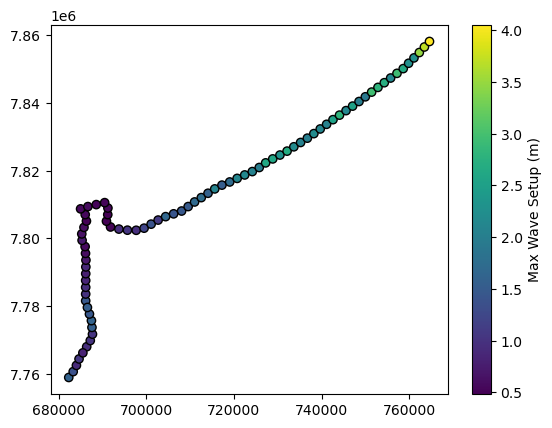

In [33]:
# check_setup_max.plot.scatter(x='x', y='y')

plt.scatter(check_setup_max['x'], check_setup_max['y'], c=check_setup_max, cmap='viridis', edgecolor='k')

plt.colorbar(label='Max Wave Setup (m)')

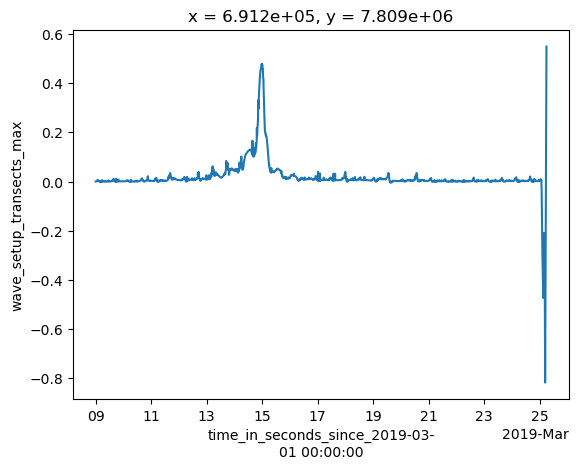

In [34]:
combined_array[:,41].plot()

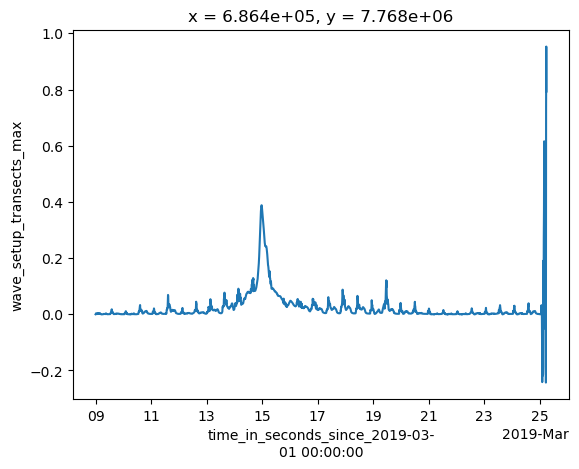

In [35]:
combined_array[:,0].plot()

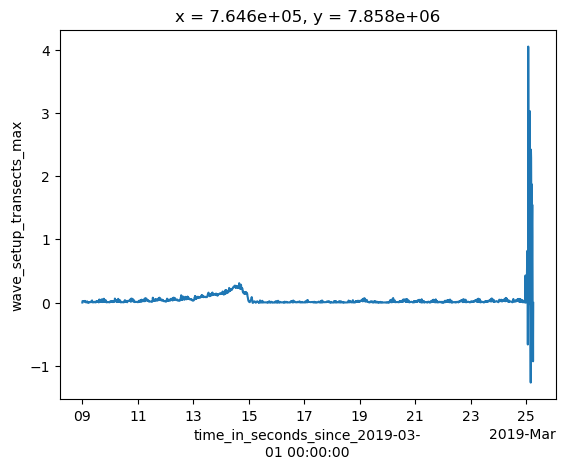

In [36]:
combined_array[:,-1].plot()

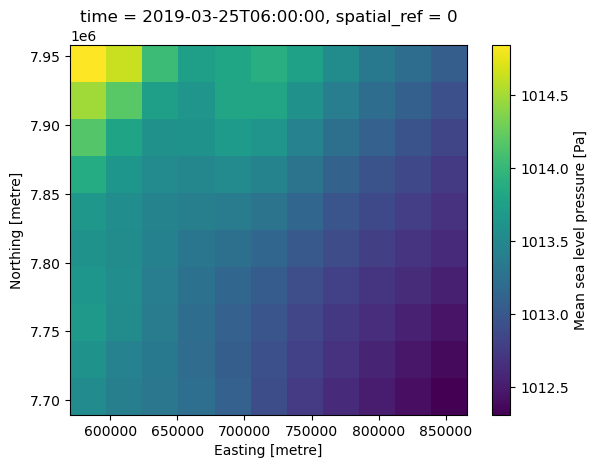

In [9]:
ncin = r'p:\11210471-001-compass\code\SFINCS\SFINCS_Idai_Wave_Tim\with_snapwave_longer\press_2d.nc'

press = xr.open_dataset(ncin)
press.time

press.barometric_pressure[-1,:,:].plot()

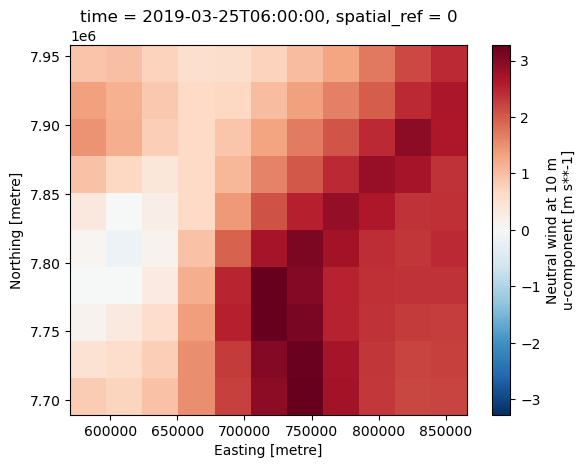

In [11]:
ncin = r'p:\11210471-001-compass\code\SFINCS\SFINCS_Idai_Wave_Tim\with_snapwave_longer\wind_2d.nc'

wind = xr.open_dataset(ncin)
wind.time

wind.eastward_wind[-1,:,:].plot()

In [10]:
ncin = r'p:\11210471-001-compass\code\SFINCS\SFINCS_Idai_Wave_Tim\with_snapwave_longer\snapwave.nc'

wave = xr.open_dataset(ncin)
wave.time

<xarray.DataArray 'time' (time: 391)> Size: 3kB
array(['2019-03-09T00:00:00.000000000', '2019-03-09T01:00:00.000000000',
       '2019-03-09T02:00:00.000000000', ..., '2019-03-25T04:00:00.000000000',
       '2019-03-25T05:00:00.000000000', '2019-03-25T06:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 3kB 2019-03-09 ... 2019-03-25T06:00:00
    spatial_ref  int32 4B ...
Attributes:
    long_name:      time
    standard_name:  time

In [ ]:
combined_array[:,0].plot()